In [5]:
# Import libraries
import pandas as pd
import numpy as np
import utils
import matplotlib.pyplot as plt

In [6]:
# Import data
input_listings = './data/seattle/listings.csv'
input_calendar = './data/seattle/calendar.csv'
# input_reviews = './data/seattle/reviews.csv'


listings = pd.read_csv(input_listings)
calendar = pd.read_csv(input_calendar)
# reviews = pd.read_csv(input_reviews)

### Data Preparation

This section is about cleansing data, transforming data into desired formats for further analysis. First, I would not use the url for this analysis, I am going to remove these columns.

In [7]:
# Remove unused columns in listings
not_required_columns = ['listing_url', 'scrape_id', 'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url', 
                        'host_url', 'host_thumbnail_url', 'host_picture_url'
                       ]
listings_df = listings[listings.columns[~listings.columns.isin(not_required_columns)]]

###	Q1 - What is the busiest time to visit Seattle in 2016?

In [8]:
# get the year and month
d = pd.DatetimeIndex(calendar['date'], dayfirst=True)
calendar['date'] = d.strftime("%d/%m/%Y")
calendar['year'] = d.year
calendar['month'] = d.month

# exclude those data for 2017
calendar = calendar[calendar['year'] < 2017]

In [9]:
# Remove $ sign from price and convert price in str to float
calendar['price'] = calendar['price'].apply(lambda x:utils.convert2float(x))

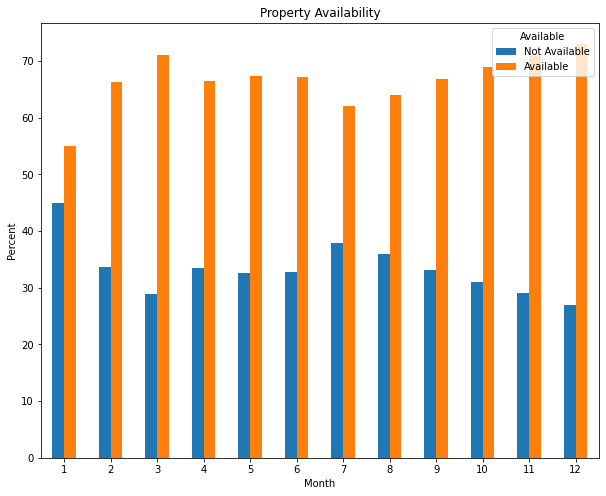

In [10]:
# plot airBnB availability
ax = pd.crosstab(calendar['month'], calendar['available']).apply(lambda r: r/r.sum()*100, axis=1)
ax_1 = ax.plot.bar(figsize=(10,8), stacked=False, rot=0)
L = plt.legend(loc='upper right', title="Available")
L.get_texts()[0].set_text('Not Available')
L.get_texts()[1].set_text('Available')
plt.title("Property Availability")
plt.xlabel("Month")
plt.ylabel("Percent")
plt.show()

### Insights
The busiest time to visit Seattle is January. January has the least amount of available rental properties on AirBnB. 

### Q2. Where are popular properties located?

In [11]:
# Find out the listing_id being unavailable with >90% of a year
# Assumption: if a property is being unavailable for 90% of a year --> role model
popular_cutoff = 365 *.9
unpopular_cutoff = 365 *.1

In [12]:
# create a subset for unavailable property
unavailableProperties = calendar[calendar['available'] == 'f']

# group the dataset by listing_id, do a row count by date
unavailablePropertiesSummary = unavailableProperties.groupby(by=['listing_id'])['date'].count().reset_index().rename(columns={'date':'date_count'}).sort_values(by ='date_count', ascending=False)

# Find out the listing_id being available with <10% of a year
popularProperties = unavailablePropertiesSummary[unavailablePropertiesSummary['date_count']>popular_cutoff]

# extract the listing_id for popular properties
popularPropertiesID = popularProperties['listing_id'].tolist()

# Create a subset for popular properties listings
popularPropertiesListings = listings_df[listings_df['id'].isin(popularPropertiesID)]

In [13]:
# create a subset for available property
availableProperties = calendar[calendar['available'] == 't']

# group the dataset by listing_id, do a row count by date
availablePropertiesSummary = availableProperties.groupby(by=['listing_id'])['date'].count().reset_index().rename(columns={'date':'date_count'}).sort_values(by ='date_count', ascending=False)

# Find out the listing_id being available with >90% of a year
unpopularProperties = availablePropertiesSummary[availablePropertiesSummary['date_count'] < unpopular_cutoff]

# extract the listing_id for popular properties
unpopularPropertiesID = unpopularProperties['listing_id'].tolist()

In [14]:
# Create a subset for popular properties listings
unpopularPropertiesListings = listings_df[listings_df['id'].isin(unpopularPropertiesID)]

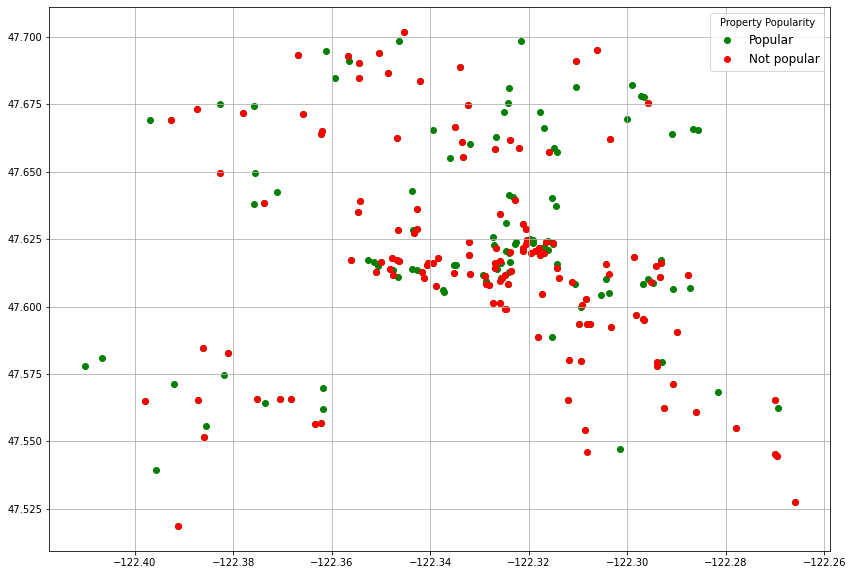

In [15]:
# populating property on map
fig, ax = plt.subplots(figsize=(14, 10))

colors_list = ['green', 'red']
property_popularity = ['Popular', 'Not popular']

popularPropertiesScatter = ax.scatter(popularPropertiesListings['longitude'],
                                      popularPropertiesListings['latitude'],
                                      c='green',
                                      label='Popular')

unpopularPropertiesScatter = ax.scatter(unpopularPropertiesListings['longitude'],
                                        unpopularPropertiesListings['latitude'],
                                        c='red',
                                        label='Unpopular')

handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors_list]
plt.legend(handlelist,property_popularity,loc='upper right', title='Property Popularity', prop={'size': 12})

ax.grid(True)
plt.show()

### Insights


### Q3 - What is the vibe of Seattle popular neighborhood?

In [16]:
districts = listings['neighbourhood_group_cleansed'].unique().tolist() 
districts = [town.lower().split() for town in districts]

districts_flat = [item for sublist in districts for item in sublist]

In [17]:
listings['neighborhood_overview_cleaned'] = listings['neighborhood_overview'].apply(lambda x: utils.clean_text(x, districts_flat))

In [18]:
downtown = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Downtown')
capitolHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Capitol Hill')
queenAnne = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Queen Anne')
ballard = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Ballard')
weatSeattle = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'West Seattle')
northgate = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Northgate')
beaconHill = utils.subset_dataset(listings, 'neighbourhood_group_cleansed', 'Beacon Hill')

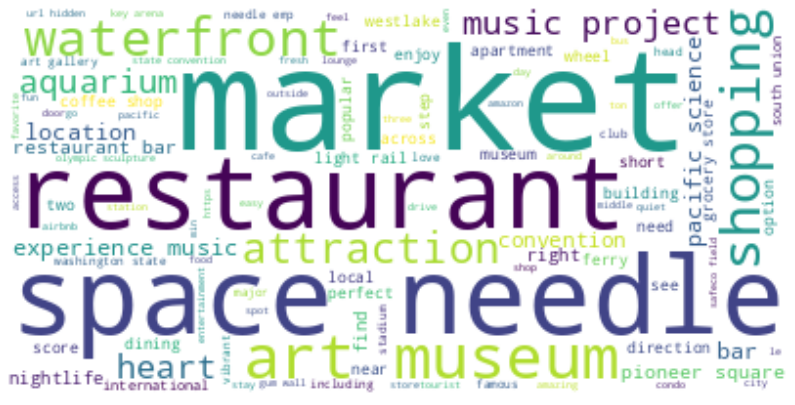

In [19]:
# downtown
utils.create_wordcloud(downtown, 'neighborhood_overview_cleaned')

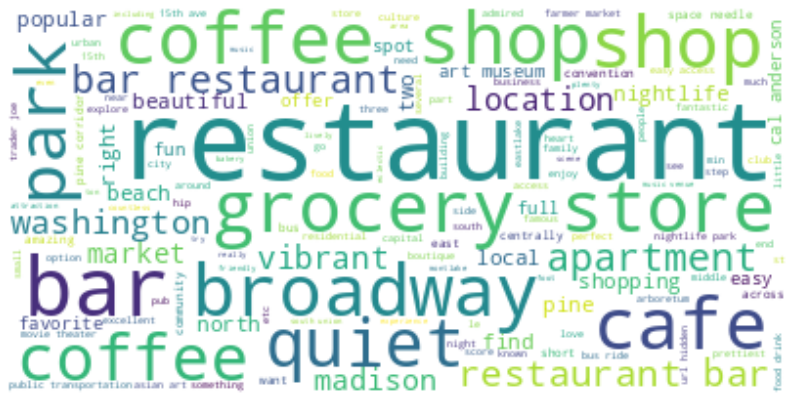

In [20]:
# capitol hill
utils.create_wordcloud(capitolHill, 'neighborhood_overview_cleaned')

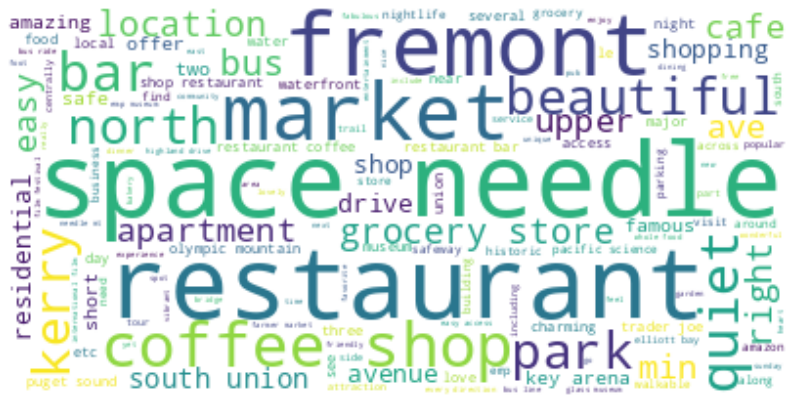

In [21]:
# queen anne
utils.create_wordcloud(queenAnne, 'neighborhood_overview_cleaned')

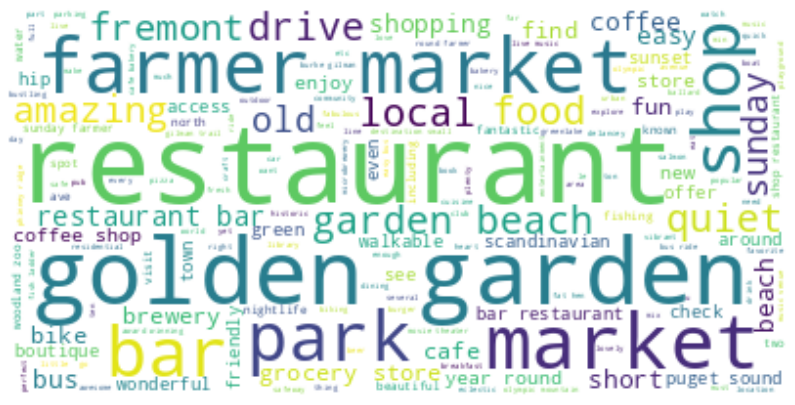

In [22]:
# ballard
utils.create_wordcloud(ballard, 'neighborhood_overview_cleaned')

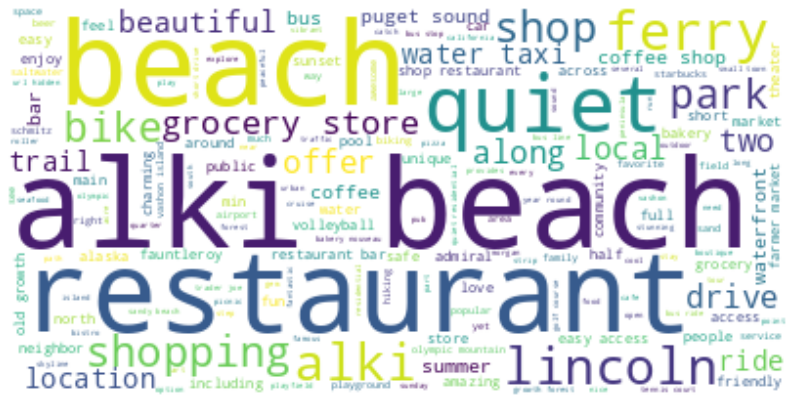

In [23]:
# west seattle
utils.create_wordcloud(weatSeattle, 'neighborhood_overview_cleaned')

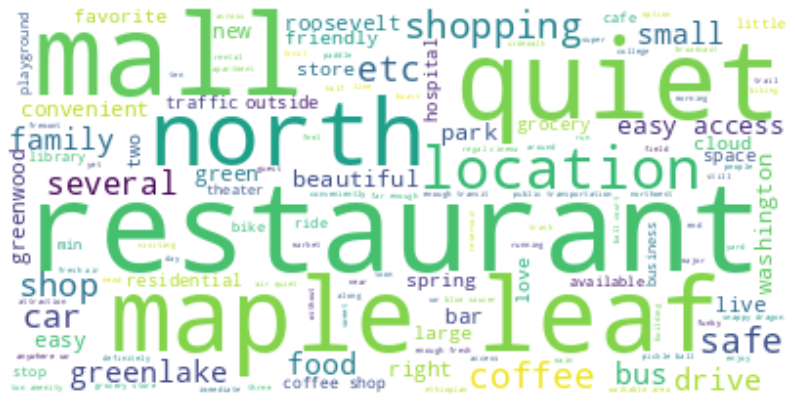

In [24]:
# north gate
utils.create_wordcloud(northgate, 'neighborhood_overview_cleaned')

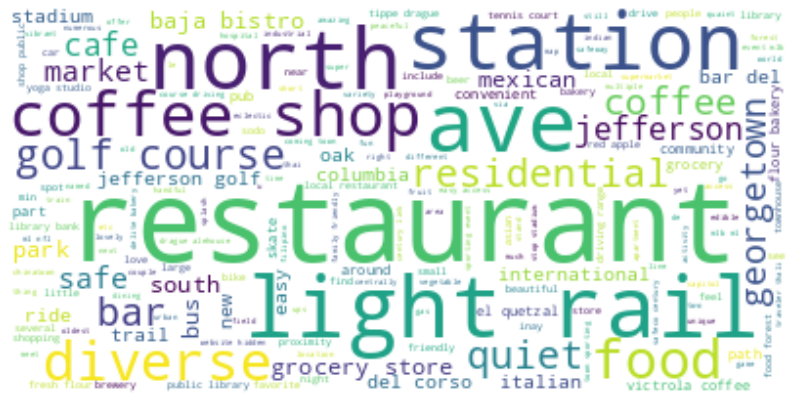

In [25]:
# beacon hill
utils.create_wordcloud(beaconHill, 'neighborhood_overview_cleaned')

## BACKUP

In [ ]:
##BACKUP

# generate random colours based on neighbourhood_group_cleansed
colors, colors_list = utils.generate_colors(popularPropertiesListings['neighbourhood_group_cleansed'])

# get the neighorhood list
districts = popularPropertiesListings['neighbourhood_group_cleansed'].unique().tolist()

# populating property on map
fig, ax = plt.subplots(figsize=(14, 10))

scatter = ax.scatter(popularPropertiesListings['longitude'],
          popularPropertiesListings['latitude'],
          c=popularPropertiesListings['neighbourhood_group_cleansed'].map(colors),
          label=colors.keys())

handlelist = [plt.plot([], marker="o", ls="", color=color)[0] for color in colors_list]
plt.legend(handlelist,districts,loc='upper right', title='neighbourhood')

ax.grid(True)
plt.show()